In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render li, div.text_cell_render p, code{font-size:22pt; line-height:40px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

         TYPE  DAYS  TEMP_CORR  RAIN_CORR  TEMP_ABS  RAIN_ABS  WEATHER_SCORE
0       커피/음료  1035  -0.237065  -0.013950  0.237065  0.013950      17.013071
1          한식  1035  -0.190211   0.021376  0.190211  0.021376      13.956029
2          분식  1035   0.110368   0.038073  0.110368  0.038073       8.867958
3  제과/제빵/떡/케익  1035  -0.092257  -0.044305  0.092257  0.044305       7.787112
4      일식/수산물  1035  -0.090776  -0.045133  0.090776  0.045133       7.708323


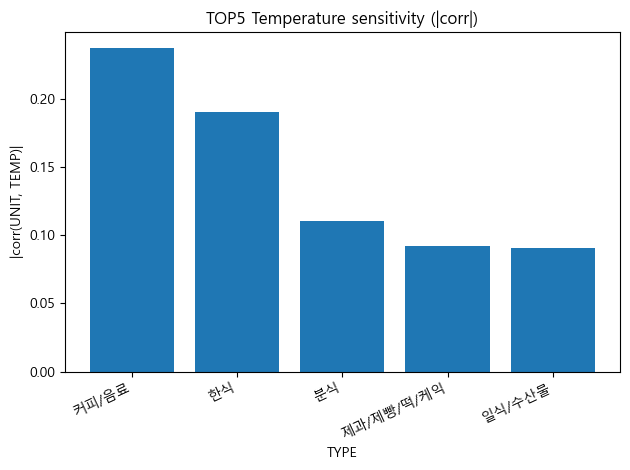

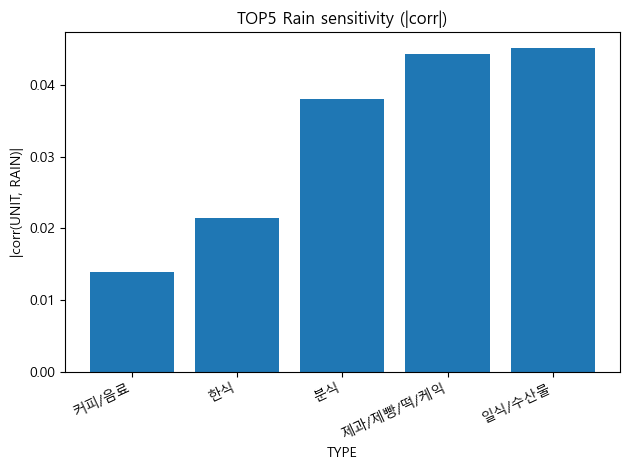

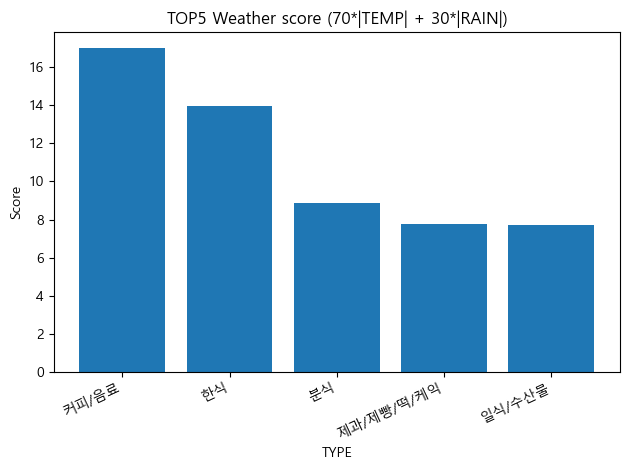

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def set_korean_font():
    import platform
    sys = platform.system()
    if sys == "Windows":
        plt.rcParams["font.family"] = "Malgun Gothic"
    elif sys == "Darwin":
        plt.rcParams["font.family"] = "AppleGothic"
    else:
        plt.rcParams["font.family"] = ["NanumGothic", "Noto Sans CJK KR", "DejaVu Sans"]
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# ====== 데이터 로드 ======
DATA_CSV = r"//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv"
df = pd.read_csv(DATA_CSV)

# 일자(TA_YMD) x 업종(TYPE) 단위로 집계 (UNIT=일 매출/판매량 합)
daily = (
    df.groupby(["TA_YMD", "TYPE"], as_index=False)
      .agg(
          UNIT=("UNIT", "sum"),
          TEMP=("TEMP", "mean"),
          RAIN=("RAIN", "mean"),
          DAY=("DAY", "first"),
          N=("UNIT", "size"),
      )
)

# ====== 업종별 상관계수/민감도 계산 ======
rows = []
for t, g in daily.groupby("TYPE"):
    if len(g) < 30:
        continue
    temp_corr = g["UNIT"].corr(g["TEMP"])
    rain_corr = g["UNIT"].corr(g["RAIN"])

    temp_abs = abs(temp_corr) if pd.notna(temp_corr) else 0.0
    rain_abs = abs(rain_corr) if pd.notna(rain_corr) else 0.0

    # 기존 점수 규칙과 동일: 70*|TEMP| + 30*|RAIN|
    score = 70 * temp_abs + 30 * rain_abs

    rows.append({
        "TYPE": t,
        "DAYS": len(g),
        "TEMP_CORR": temp_corr,
        "RAIN_CORR": rain_corr,
        "TEMP_ABS": temp_abs,
        "RAIN_ABS": rain_abs,
        "WEATHER_SCORE": score
    })

sens = pd.DataFrame(rows).sort_values("WEATHER_SCORE", ascending=False).reset_index(drop=True)
top5 = sens.head(5).copy()
print(top5)

# ====== TOP5 그래프 ======
plt.figure()
plt.bar(top5["TYPE"].astype(str), top5["TEMP_ABS"])
plt.xticks(rotation=25, ha="right")
plt.title("TOP5 Temperature sensitivity (|corr|)")
plt.xlabel("TYPE")
plt.ylabel("|corr(UNIT, TEMP)|")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(top5["TYPE"].astype(str), top5["RAIN_ABS"])
plt.xticks(rotation=25, ha="right")
plt.title("TOP5 Rain sensitivity (|corr|)")
plt.xlabel("TYPE")
plt.ylabel("|corr(UNIT, RAIN)|")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(top5["TYPE"].astype(str), top5["WEATHER_SCORE"])
plt.xticks(rotation=25, ha="right")
plt.title("TOP5 Weather score (70*|TEMP| + 30*|RAIN|)")
plt.xlabel("TYPE")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

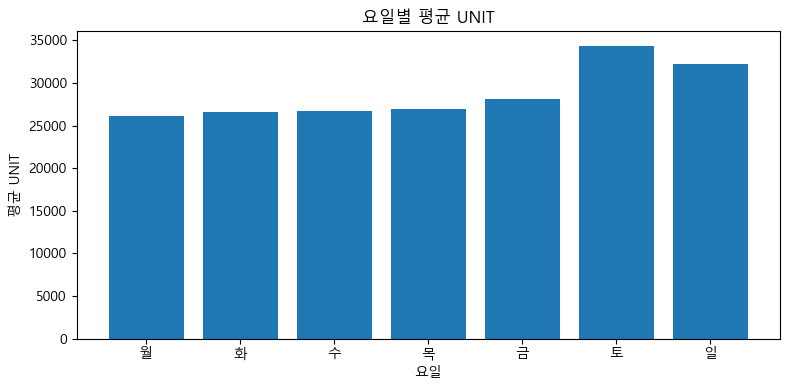

저장: C:\ai\source\10_1stProject\viz_output\30_dayofweek_avg_unit_bar.png


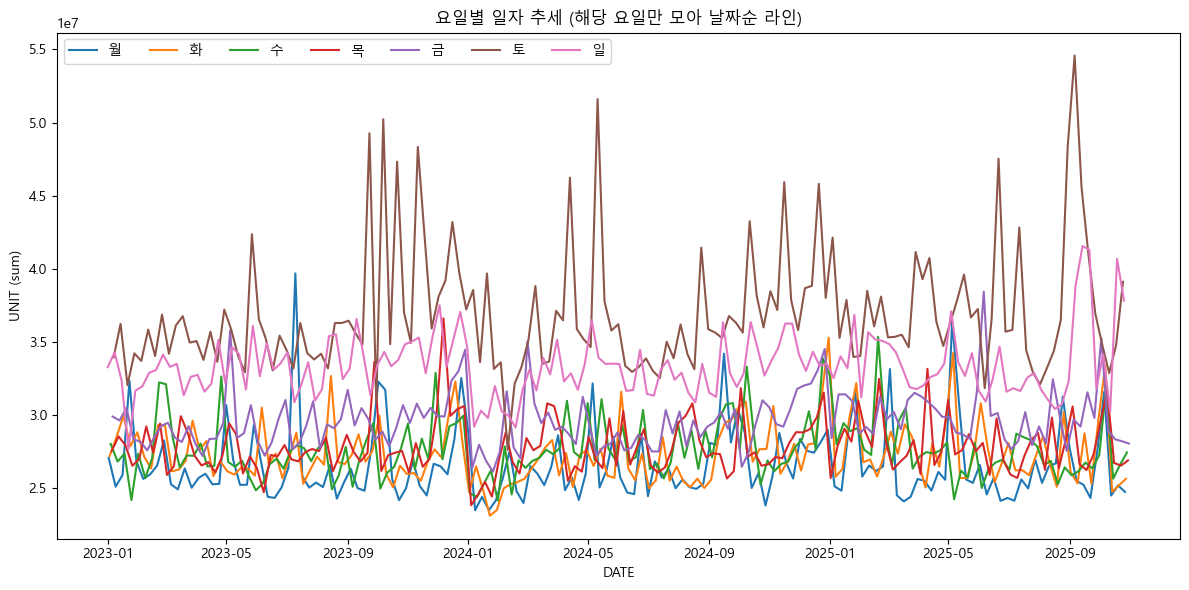

저장: C:\ai\source\10_1stProject\viz_output\31_dayofweek_trend_lines.png


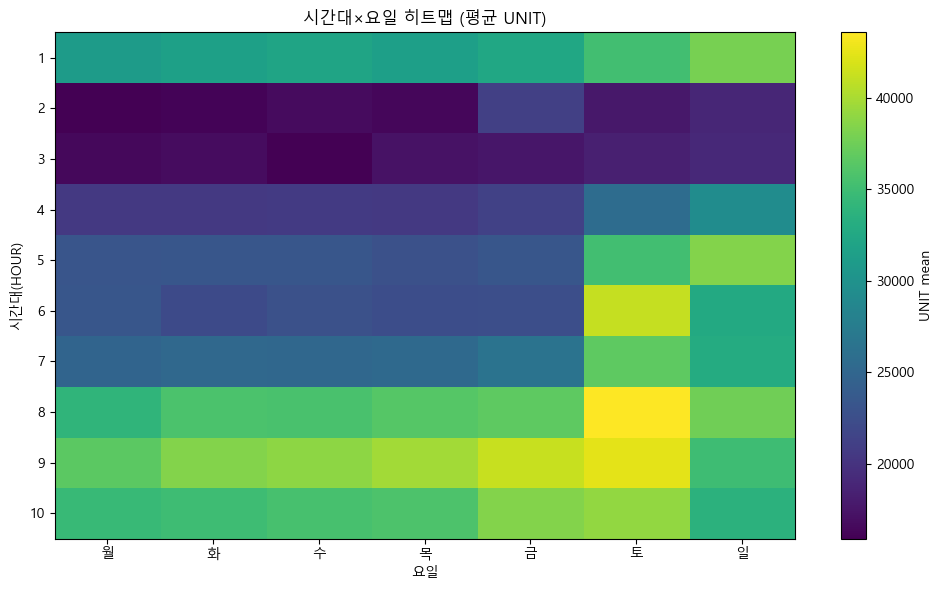

저장: C:\ai\source\10_1stProject\viz_output\32_hour_x_day_heatmap_mean_unit.png


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATA_PATH = r"//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv"
OUT_DIR = "./viz_output"
os.makedirs(OUT_DIR, exist_ok=True)



# =========================
DATA_PATH = r"//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv"
OUT_DIR = "./viz_output"
os.makedirs(OUT_DIR, exist_ok=True)

def save_show(fig, filename):
    path = os.path.join(OUT_DIR, filename)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
    print("저장:", os.path.abspath(path))

def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# =========================
# 1) Load
# =========================
df = pd.read_csv(DATA_PATH)

# DATE 만들기
if "TA_YMD" in df.columns:
    df["DATE"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")
elif "DATE" in df.columns:
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
else:
    raise ValueError("TA_YMD 또는 DATE 컬럼이 필요합니다.")

COL_UNIT = pick_first_existing(df, ["UNIT", "AMT", "amt", "매출"])
COL_DAY  = pick_first_existing(df, ["DAY", "day", "요일"])
COL_HOUR = pick_first_existing(df, ["HOUR", "hour", "시간대"])  # 있으면 히트맵 추가

if COL_UNIT is None or COL_DAY is None:
    raise ValueError(f"필수 컬럼 누락: UNIT({COL_UNIT}), DAY({COL_DAY})\n현재 컬럼:{df.columns.tolist()}")

df[COL_UNIT] = pd.to_numeric(df[COL_UNIT], errors="coerce")
df = df.dropna(subset=["DATE", COL_UNIT, COL_DAY]).copy()

# =========================
# 2) 요일 값 정리(숫자/문자 대응)
# =========================
# DAY가 0~6/1~7 같은 숫자면 한글 요일로 매핑
day_map_0to6 = {0:"월",1:"화",2:"수",3:"목",4:"금",5:"토",6:"일"}
day_map_1to7 = {1:"월",2:"화",3:"수",4:"목",5:"금",6:"토",7:"일"}

# 문자열이면 그대로 쓰되 공백 제거
if np.issubdtype(df[COL_DAY].dtype, np.number):
    vals = df[COL_DAY].astype(int)
    if set(vals.unique()).issubset(set(day_map_0to6.keys())):
        df["DAY_KR"] = vals.map(day_map_0to6)
    elif set(vals.unique()).issubset(set(day_map_1to7.keys())):
        df["DAY_KR"] = vals.map(day_map_1to7)
    else:
        df["DAY_KR"] = vals.astype(str)
else:
    df["DAY_KR"] = df[COL_DAY].astype(str).str.strip()

# 보기 좋은 순서(월~일)
order = ["월","화","수","목","금","토","일"]
# 데이터에 그 외 값이 있으면 뒤에 붙임
extra = [x for x in df["DAY_KR"].unique().tolist() if x not in order]
day_order = order + sorted(extra)

# =========================
# 3) (1) 요일별 평균 UNIT (Bar)
# =========================
g_mean = (df.groupby("DAY_KR", as_index=False)[COL_UNIT].mean())
g_mean["DAY_KR"] = pd.Categorical(g_mean["DAY_KR"], categories=day_order, ordered=True)
g_mean = g_mean.sort_values("DAY_KR")

fig = plt.figure(figsize=(8, 4))
plt.bar(g_mean["DAY_KR"].astype(str), g_mean[COL_UNIT])
plt.title("요일별 평균 UNIT")
plt.xlabel("요일")
plt.ylabel("평균 UNIT")
save_show(fig, "30_dayofweek_avg_unit_bar.png")

# =========================
# 4) (2) 요일별 '추세' 라인 (각 요일만 골라 날짜순)
#     - 요일별로 날짜별 합계/평균을 만든 후 라인으로 비교
# =========================
daily_by_day = (df.groupby(["DATE", "DAY_KR"], as_index=False)[COL_UNIT].sum()
                .sort_values("DATE"))

fig = plt.figure(figsize=(12, 6))
for d in [x for x in day_order if x in daily_by_day["DAY_KR"].unique()]:
    sub = daily_by_day[daily_by_day["DAY_KR"] == d]
    plt.plot(sub["DATE"], sub[COL_UNIT], label=str(d))
plt.title("요일별 일자 추세 (해당 요일만 모아 날짜순 라인)")
plt.xlabel("DATE")
plt.ylabel("UNIT (sum)")
plt.legend(ncol=7, fontsize=10)
save_show(fig, "31_dayofweek_trend_lines.png")

# =========================
# 5) (3) 요일×시간대 히트맵(평균 UNIT) - HOUR 컬럼 있을 때만
# =========================
if COL_HOUR is not None and COL_HOUR in df.columns:
    tmp = df.dropna(subset=[COL_HOUR]).copy()
    tmp[COL_HOUR] = pd.to_numeric(tmp[COL_HOUR], errors="coerce")
    tmp = tmp.dropna(subset=[COL_HOUR]).copy()
    tmp[COL_HOUR] = tmp[COL_HOUR].astype(int)

    pivot = tmp.pivot_table(index=COL_HOUR, columns="DAY_KR", values=COL_UNIT, aggfunc="mean")
    # 요일 순서 정렬
    pivot = pivot.reindex(columns=[c for c in day_order if c in pivot.columns])
    pivot = pivot.sort_index()

    fig = plt.figure(figsize=(10, 6))
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="UNIT mean")
    plt.title("시간대×요일 히트맵 (평균 UNIT)")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=0)
    plt.xlabel("요일")
    plt.ylabel("시간대(HOUR)")
    save_show(fig, "32_hour_x_day_heatmap_mean_unit.png")
else:
    print("[INFO] HOUR 컬럼이 없어 '시간대×요일 히트맵'은 생략했습니다.")


<Figure size 1400x600 with 0 Axes>

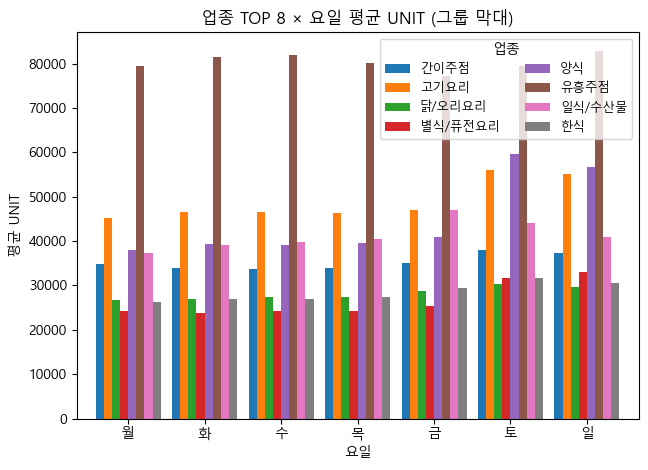

저장: C:\ai\source\10_1stProject\viz_output\40_top_types_x_day_avg_unit_groupbar.png
[INFO] 더운날(상위10%) TEMP >= 26.25
[INFO] 추운날(하위10%) TEMP <= -2.10


<Figure size 1400x600 with 0 Axes>

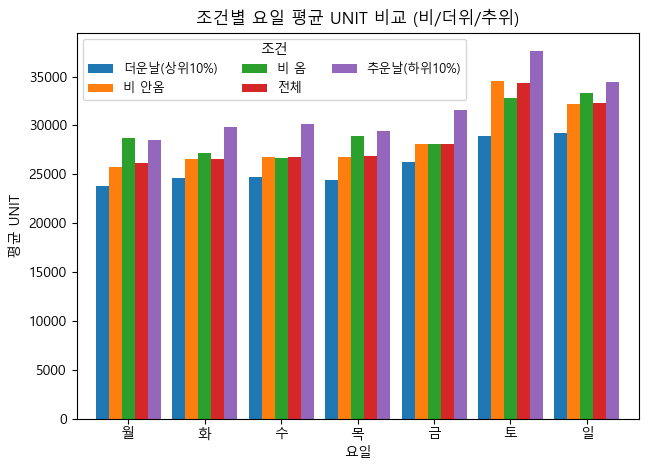

저장: C:\ai\source\10_1stProject\viz_output\41_conditions_x_day_avg_unit_groupbar.png


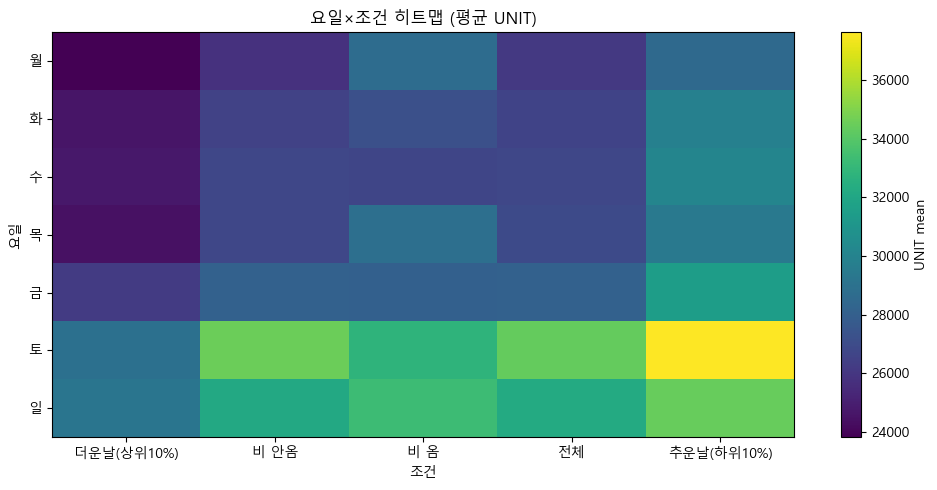

저장: C:\ai\source\10_1stProject\viz_output\42_day_x_conditions_heatmap_mean_unit.png


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) 설정
# =========================
DATA_PATH = r"//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv"
OUT_DIR = "./viz_output"
os.makedirs(OUT_DIR, exist_ok=True)

def save_show(fig, filename):
    path = os.path.join(OUT_DIR, filename)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
    print("저장:", os.path.abspath(path))

def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

if "TA_YMD" in df.columns:
    df["DATE"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")

COL_UNIT = pick_first_existing(df, ["UNIT", "AMT", "amt", "매출"])
COL_TEMP = pick_first_existing(df, ["TEMP", "temp", "기온"])
COL_RAIN = pick_first_existing(df, ["RAIN", "rain", "강수", "강수량"])
COL_TYPE = pick_first_existing(df, ["TYPE", "type", "업종"])

col_map = {"UNIT": COL_UNIT, "TEMP": COL_TEMP, "RAIN": COL_RAIN, "TYPE": COL_TYPE}
missing = [k for k, v in col_map.items() if v is None]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}\n현재 컬럼: {df.columns.tolist()}")

# 숫자 변환
for c in [COL_UNIT, COL_TEMP, COL_RAIN]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[COL_UNIT, COL_TEMP, COL_RAIN, COL_TYPE]).copy()


# =========================
# =========================
# [추가 1] 업종 TOP N × 요일 평균 UNIT (그룹 막대)
# =========================
COL_TYPE = pick_first_existing(df, ["TYPE", "type", "업종"])
COL_TEMP = pick_first_existing(df, ["TEMP", "temp", "기온"])
COL_RAIN = pick_first_existing(df, ["RAIN", "rain", "강수", "강수량"])

if COL_TYPE is None:
    print("[SKIP] TYPE 컬럼이 없어 '업종×요일' 그래프는 생략합니다.")
else:
    TOP_N_TYPES = 8

    # 업종 TOP N 선정(총 UNIT 기준)
    top_types = (df.groupby(COL_TYPE)[COL_UNIT].sum()
                   .sort_values(ascending=False)
                   .head(TOP_N_TYPES).index.tolist())

    d = df[df[COL_TYPE].isin(top_types)].copy()

    # 업종×요일 평균
    pivot = d.pivot_table(index="DAY_KR", columns=COL_TYPE, values=COL_UNIT, aggfunc="mean").fillna(0)

    # 요일 순서 정렬(앞에서 만든 day_order 사용)
    pivot = pivot.reindex([x for x in day_order if x in pivot.index])

    fig = plt.figure(figsize=(14, 6))
    pivot.plot(kind="bar", width=0.85)
    plt.title(f"업종 TOP {TOP_N_TYPES} × 요일 평균 UNIT (그룹 막대)")
    plt.xticks(rotation=0, ha="center")
    plt.tight_layout()
    plt.xlabel("요일")
    plt.ylabel("평균 UNIT")
    plt.legend(title="업종", ncol=2, fontsize=9)
    save_show(fig, "40_top_types_x_day_avg_unit_groupbar.png")


# =========================
# [추가 2] 비/더위/추위 조건별 요일 패턴 비교
#  - 더위/추위는 분위수 자동 설정(상위 10%, 하위 10%)
# =========================
if (COL_TEMP is None) or (COL_RAIN is None):
    print("[SKIP] TEMP 또는 RAIN 컬럼이 없어 '비/더위/추위 요일 비교'는 생략합니다.")
else:
    # 분위수 기반 임계값
    hot_th = df[COL_TEMP].dropna().quantile(0.90)
    cold_th = df[COL_TEMP].dropna().quantile(0.10)

    print(f"[INFO] 더운날(상위10%) TEMP >= {hot_th:.2f}")
    print(f"[INFO] 추운날(하위10%) TEMP <= {cold_th:.2f}")

    base = df.dropna(subset=[COL_TEMP, COL_RAIN]).copy()

    conds = {
        "전체": base,
        "비 안옴": base[base[COL_RAIN] <= 0],
        "비 옴": base[base[COL_RAIN] > 0],
        "더운날(상위10%)": base[base[COL_TEMP] >= hot_th],
        "추운날(하위10%)": base[base[COL_TEMP] <= cold_th],
    }

    # 조건별 요일 평균 UNIT 테이블 만들기
    table = []
    for name, sub in conds.items():
        if sub.empty:
            continue
        g = sub.groupby("DAY_KR", as_index=False)[COL_UNIT].mean()
        g["COND"] = name
        table.append(g)

    comp = pd.concat(table, ignore_index=True)

    # 피벗: 요일(행) × 조건(열)
    pivot = comp.pivot_table(index="DAY_KR", columns="COND", values=COL_UNIT, aggfunc="mean").fillna(0)
    pivot = pivot.reindex([x for x in day_order if x in pivot.index])

    # (2-1) 그룹 막대: 요일별로 조건 비교
    fig = plt.figure(figsize=(14, 6))
    pivot.plot(kind="bar", width=0.85)
    plt.title("조건별 요일 평균 UNIT 비교 (비/더위/추위)")
    plt.xticks(rotation=0, ha="center")
    plt.tight_layout()
    plt.xlabel("요일")
    plt.ylabel("평균 UNIT")
    plt.legend(title="조건", ncol=3, fontsize=9)
    save_show(fig, "41_conditions_x_day_avg_unit_groupbar.png")

    # (2-2) 히트맵: 요일×조건 (평균 UNIT)
    # 값 크기 패턴을 한눈에 보기 좋음
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="UNIT mean")
    plt.title("요일×조건 히트맵 (평균 UNIT)")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=0, ha="center")
    plt.xlabel("조건")
    plt.ylabel("요일")
    save_show(fig, "42_day_x_conditions_heatmap_mean_unit.png")


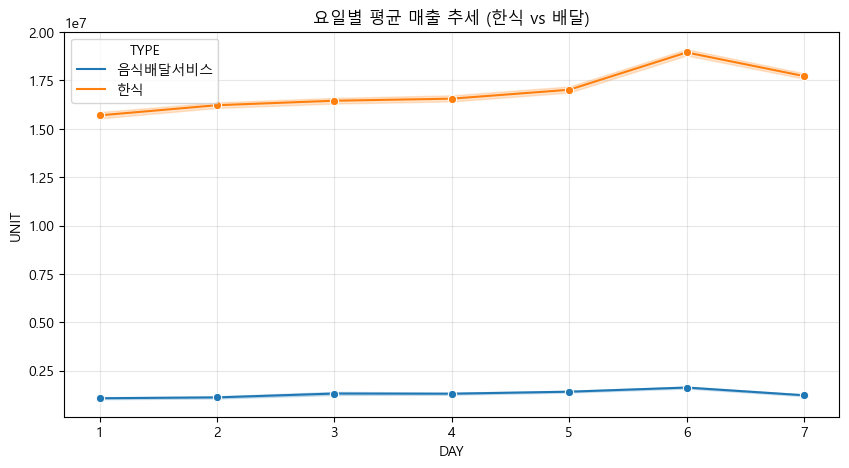

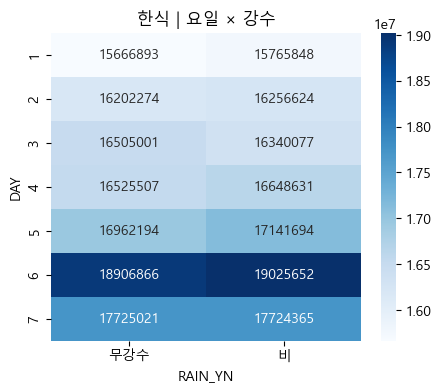

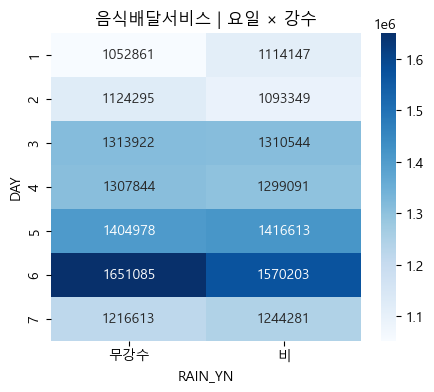

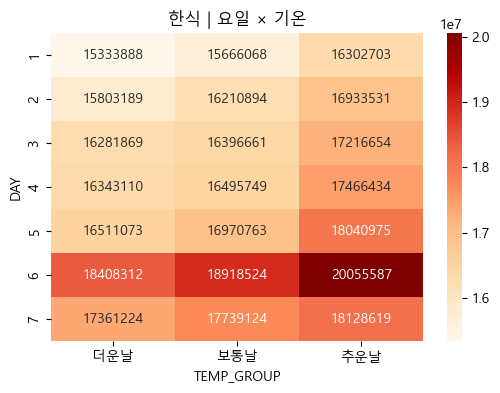

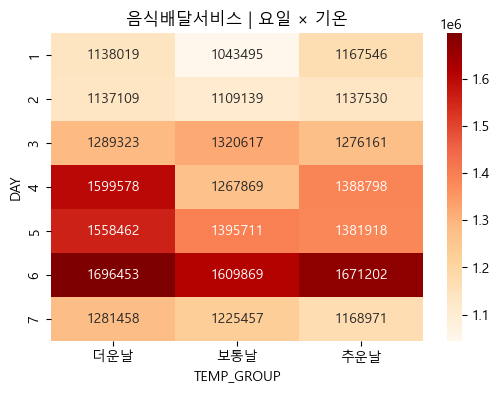

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# =========================
# 1. 데이터 로드
# =========================
base = pd.read_csv("//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv")
hansik_backup = pd.read_csv("//192.168.0.230/data/suwon_data/수원시 한식 데이터백업.csv")
delivery_backup = pd.read_csv("//192.168.0.230/data/suwon_data/수원시 배달 데이터백업.csv")

# 업종명 강제 통일
hansik_backup["TYPE"] = "한식"
delivery_backup["TYPE"] = "음식배달서비스"

# 컬럼 맞추기 (없는 컬럼은 NaN)
common_cols = set(base.columns) | set(hansik_backup.columns) | set(delivery_backup.columns)

def align_cols(df):
    for c in common_cols:
        if c not in df.columns:
            df[c] = np.nan
    return df[list(common_cols)]

base = align_cols(base)
hansik_backup = align_cols(hansik_backup)
delivery_backup = align_cols(delivery_backup)

df = pd.concat([base, hansik_backup, delivery_backup], ignore_index=True)

# =========================
# 2. 날짜 정리
# =========================
df["TA_YMD"] = df["TA_YMD"].astype(str)
df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

# =========================
# 3. 한식 + 배달만
# =========================
df = df[df["TYPE"].isin(["한식", "음식배달서비스"])].copy()

# =========================
# 4. 일자 × 업종 집계
# =========================
daily = (
    df.groupby(["DATE", "TA_YMD", "TYPE"], as_index=False)
      .agg(
          UNIT=("UNIT", "sum"),
          TEMP=("TEMP", "mean"),
          RAIN=("RAIN", "mean"),
          DAY=("DAY", "first")
      )
)

# =========================
# 5. 파생 변수
# =========================
daily["RAIN_YN"] = np.where(daily["RAIN"] > 0, "비", "무강수")

low_q = daily["TEMP"].quantile(0.1)
high_q = daily["TEMP"].quantile(0.9)

def temp_group(x):
    if x <= low_q:
        return "추운날"
    elif x >= high_q:
        return "더운날"
    else:
        return "보통날"

daily["TEMP_GROUP"] = daily["TEMP"].apply(temp_group)

# =========================
# 6️⃣ 요일별 매출 추세
# =========================
plt.figure(figsize=(10,5))
sns.lineplot(
    data=daily,
    x="DAY", y="UNIT",
    hue="TYPE",
    estimator="mean",
    marker="o"
)
plt.title("요일별 평균 매출 추세 (한식 vs 배달)")
plt.grid(alpha=0.3)
plt.show()
new_SAVE_PATH = "C:/ai/source/10_1stProject/요일별 한식_배달_추세.png"
fig.tight_layout()
fig.savefig(new_SAVE_PATH, dpi=300, bbox_inches="tight")

# =========================
# 7️⃣ 요일 × 강수 히트맵
# =========================
pivot_rain = (
    daily.groupby(["TYPE", "DAY", "RAIN_YN"])["UNIT"]
    .mean()
    .reset_index()
)

for t in ["한식", "음식배달서비스"]:
    heat = pivot_rain[pivot_rain["TYPE"] == t].pivot(
        index="DAY", columns="RAIN_YN", values="UNIT"
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(heat, annot=True, fmt=".0f", cmap="Blues")
    plt.title(f"{t} | 요일 × 강수")
    plt.show()

# =========================
# 8️⃣ 요일 × 기온 히트맵
# =========================
pivot_temp = (
    daily.groupby(["TYPE", "DAY", "TEMP_GROUP"])["UNIT"]
    .mean()
    .reset_index()
)

for t in ["한식", "음식배달서비스"]:
    heat = pivot_temp[pivot_temp["TYPE"] == t].pivot(
        index="DAY", columns="TEMP_GROUP", values="UNIT"
    )
    plt.figure(figsize=(6,4))
    sns.heatmap(heat, annot=True, fmt=".0f", cmap="OrRd")
    plt.title(f"{t} | 요일 × 기온")
    plt.show()

# =========================
# 9️⃣ 요일+날씨 조합 추천
# =========================
baseline = daily.groupby("TYPE")["UNIT"].mean()

recommend = (
    daily.groupby(["TYPE", "DAY", "RAIN_YN"])["UNIT"]
    .mean()
    .reset_index()
)

recommend["매출증가율(%)"] = recommend.apply(
    lambda x: (x["UNIT"] / baseline[x["TYPE"]] - 1) * 100,
    axis=1
)
SAVE_PATH = "C:/ai/source/10_1stProject/한식_배달_추세.png"
fig.tight_layout()
fig.savefig(SAVE_PATH, dpi=300, bbox_inches="tight")

ℹ️ slot이 없어서 파일에서 새로 생성합니다...

--- slot 점검 ---
rows: 16545  cols: 11
TYPE unique: ['음식배달서비스' '한식']
DAY_STD unique: ['화' '수' '목' '금' '토' '일']
HOUR_STD min/max: (1, 10)


C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1157027680.py:125: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=pv1, x="HOUR_STD", y="UNIT", hue="TYPE", ci=None, ax=ax1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1157027680.py:131: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=pv2, x="DAY_STD", y="UNIT", hue="TYPE", order=day_order, ci=None, ax=ax2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1157027680.py:138: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=pv3, x="HOUR_STD", y="UNIT", hue="TYPE_RAIN", ci=None, ax=ax3)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1157027680.py:148: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=pv4, x="HOUR_STD", y="UNIT", hue="TYPE_TEMP", ci=None, ax=ax4)


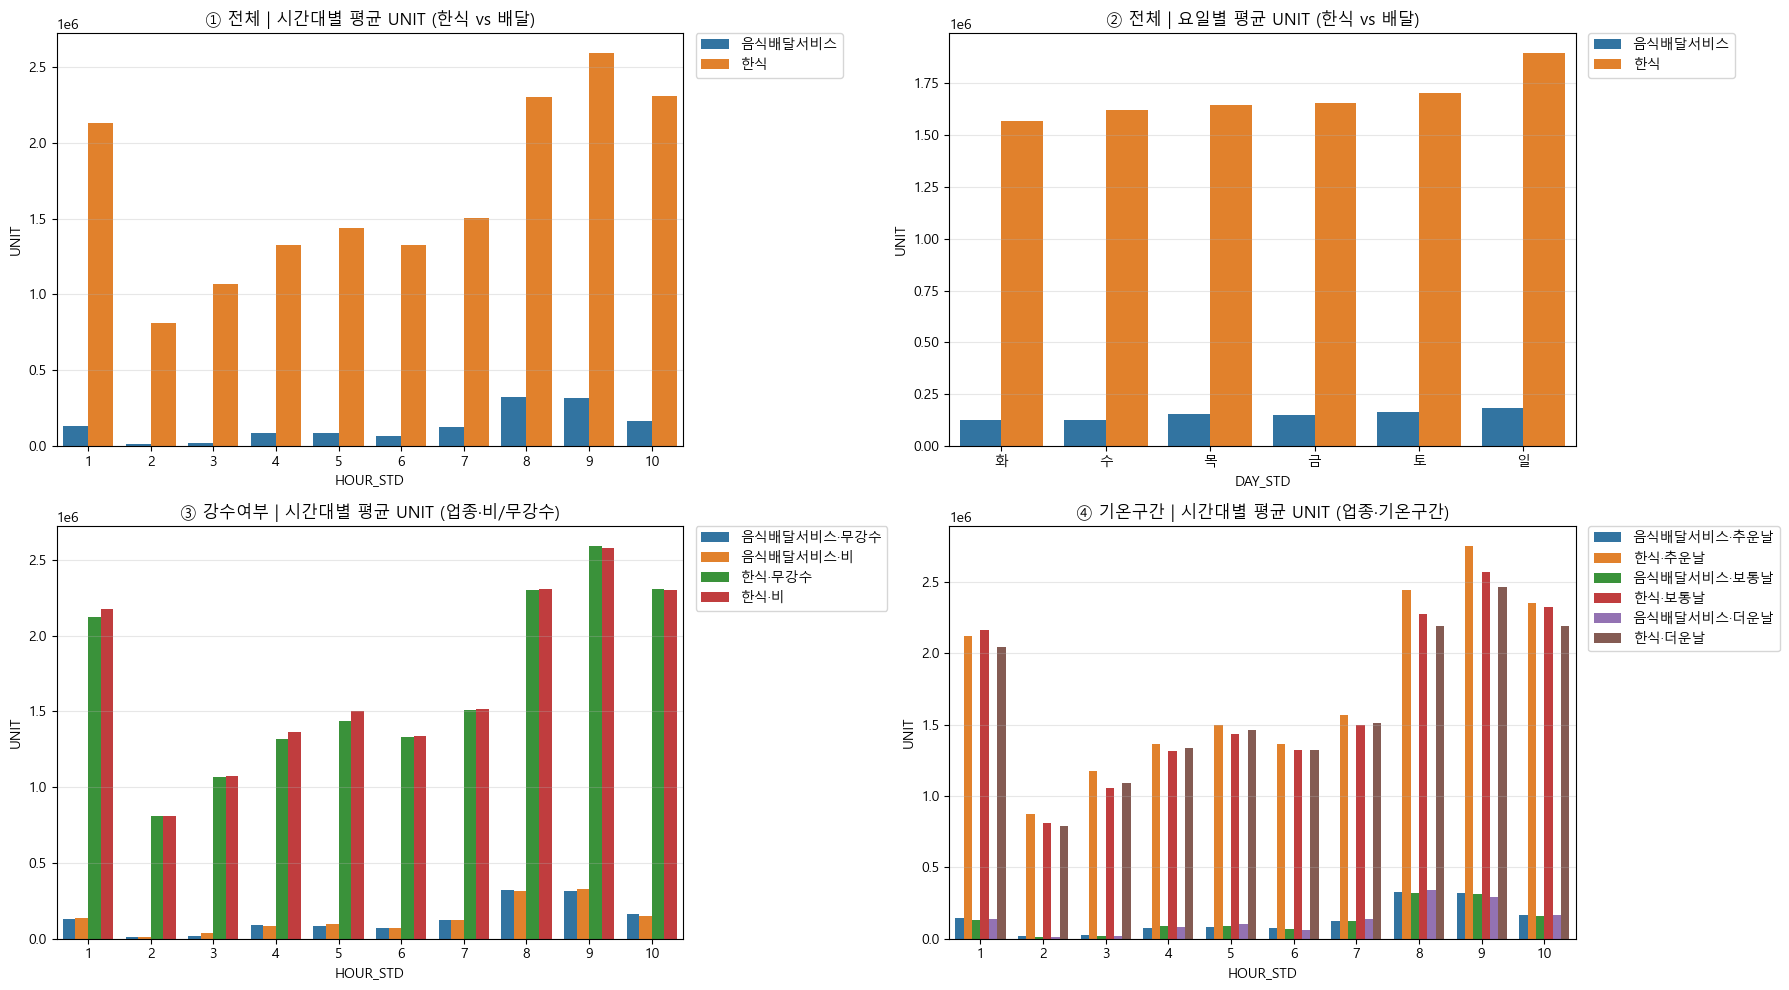

✅ 저장 완료: C:/ai/source/10_1stProject/한식_배달_통합막대.png


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# =========================
# ✅ 0) slot이 이미 있으면 그대로 쓰고,
# 없으면 파일에서 다시 만들어줌
# =========================
try:
    slot  # noqa
    print("✅ slot이 이미 존재함. 기존 slot 사용.")
except NameError:
    print("ℹ️ slot이 없어서 파일에서 새로 생성합니다...")



    hansik_backup["TYPE"] = "한식"
    delivery_backup["TYPE"] = "음식배달서비스"

    common_cols = set(base.columns) | set(hansik_backup.columns) | set(delivery_backup.columns)

    def align_cols(df):
        for c in common_cols:
            if c not in df.columns:
                df[c] = np.nan
        return df[list(common_cols)]

    df = pd.concat([align_cols(base), align_cols(hansik_backup), align_cols(delivery_backup)], ignore_index=True)

    # 숫자형 강제 변환
    for c in ["UNIT", "TEMP", "RAIN"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df["UNIT"] = df["UNIT"].fillna(0)

    # 시간대 컬럼 자동 인식
    HOUR_CANDIDATES = ["HOUR", "hour", "SLOT", "slot", "TIME_SLOT", "TIME", "TM"]
    hour_col = next((c for c in HOUR_CANDIDATES if c in df.columns), None)
    if hour_col is None:
        raise KeyError(f"시간대 컬럼을 찾지 못했어. 후보={HOUR_CANDIDATES} / 현재컬럼 일부={list(df.columns)[:50]}")

    df[hour_col] = pd.to_numeric(df[hour_col], errors="coerce")
    df = df.dropna(subset=[hour_col]).copy()
    df["HOUR_STD"] = df[hour_col].astype(int)

    # 날짜
    df["TA_YMD"] = df["TA_YMD"].astype(str)
    df["DATE"] = pd.to_datetime(df["TA_YMD"], format="%Y%m%d", errors="coerce")

    # 한식/배달만
    TARGET_TYPES = ["한식", "음식배달서비스"]
    df = df[df["TYPE"].isin(TARGET_TYPES)].copy()

    # 집계: 일자×시간대×업종
    slot = (
        df.groupby(["DATE", "TA_YMD", "TYPE", "HOUR_STD"], as_index=False)
          .agg(UNIT=("UNIT", "sum"), TEMP=("TEMP", "mean"), RAIN=("RAIN", "mean"), DAY=("DAY", "first"))
    )

    slot["TEMP"] = slot["TEMP"].fillna(slot["TEMP"].median())
    slot["RAIN"] = slot["RAIN"].fillna(0)
    slot = slot.dropna(subset=["DAY"]).copy()

    # 파생: 비/무강수
    slot["RAIN_YN"] = np.where(slot["RAIN"] > 0, "비", "무강수")

    # 기온구간(분위수)
    low_q = slot["TEMP"].quantile(0.1)
    high_q = slot["TEMP"].quantile(0.9)

    def temp_group(x):
        if x <= low_q:
            return "추운날"
        elif x >= high_q:
            return "더운날"
        else:
            return "보통날"
    slot["TEMP_GROUP"] = slot["TEMP"].apply(temp_group)

    # 요일 정규화
    def normalize_day(x):
        if pd.isna(x):
            return np.nan
        s = str(x).strip()
        if s.isdigit():
            m = {"0":"월","1":"화","2":"수","3":"목","4":"금","5":"토","6":"일"}
            return m.get(s, np.nan)
        s = s.replace("요일", "").strip()
        if len(s) >= 1 and s[0] in list("월화수목금토일"):
            return s[0]
        return np.nan

    slot["DAY_STD"] = slot["DAY"].apply(normalize_day)
    slot = slot.dropna(subset=["DAY_STD"]).copy()

# =========================
# ✅ 1) slot 상태 점검 (여기 출력 꼭 확인)
# =========================
print("\n--- slot 점검 ---")
print("rows:", len(slot), " cols:", len(slot.columns))
print("TYPE unique:", slot["TYPE"].unique() if "TYPE" in slot.columns else "없음")
print("DAY_STD unique:", slot["DAY_STD"].unique() if "DAY_STD" in slot.columns else "없음")
print("HOUR_STD min/max:", (slot["HOUR_STD"].min(), slot["HOUR_STD"].max()) if "HOUR_STD" in slot.columns else "없음")

if len(slot) == 0:
    raise ValueError("slot이 0행이라 그래프를 그릴 수 없어. (필터/컬럼 문제 가능)")

# 요일 순서
cand = ["월","화","수","목","금","토","일"]
uniq_days = [d for d in cand if d in slot["DAY_STD"].unique()]
day_order = uniq_days if uniq_days else sorted(slot["DAY_STD"].unique())

# =========================
# ✅ 2) 1~4를 한 Figure(2x2) 막대그래프로 출력
# =========================
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
ax1, ax2, ax3, ax4 = axes.ravel()

# (1) 시간대별 평균 (한식 vs 배달)
pv1 = slot.groupby(["TYPE","HOUR_STD"], as_index=False)["UNIT"].mean()
sns.barplot(data=pv1, x="HOUR_STD", y="UNIT", hue="TYPE", ci=None, ax=ax1)
ax1.set_title("① 전체 | 시간대별 평균 UNIT (한식 vs 배달)")
ax1.grid(axis="y", alpha=0.3)

# (2) 요일별 평균 (한식 vs 배달)
pv2 = slot.groupby(["TYPE","DAY_STD"], as_index=False)["UNIT"].mean()
sns.barplot(data=pv2, x="DAY_STD", y="UNIT", hue="TYPE", order=day_order, ci=None, ax=ax2)
ax2.set_title("② 전체 | 요일별 평균 UNIT (한식 vs 배달)")
ax2.grid(axis="y", alpha=0.3)

# (3) 강수여부 포함 시간대별 평균 (4개 그룹)
pv3 = slot.groupby(["TYPE","RAIN_YN","HOUR_STD"], as_index=False)["UNIT"].mean()
pv3["TYPE_RAIN"] = pv3["TYPE"] + "·" + pv3["RAIN_YN"]
sns.barplot(data=pv3, x="HOUR_STD", y="UNIT", hue="TYPE_RAIN", ci=None, ax=ax3)
ax3.set_title("③ 강수여부 | 시간대별 평균 UNIT (업종·비/무강수)")
ax3.grid(axis="y", alpha=0.3)

# (4) 기온구간 포함 시간대별 평균 (6개 그룹)
pv4 = slot.groupby(["TYPE","TEMP_GROUP","HOUR_STD"], as_index=False)["UNIT"].mean()
pv4["TYPE_TEMP"] = pv4["TYPE"] + "·" + pv4["TEMP_GROUP"]
order_temp = ["추운날","보통날","더운날"]
pv4["TEMP_GROUP"] = pd.Categorical(pv4["TEMP_GROUP"], categories=order_temp, ordered=True)
pv4 = pv4.sort_values(["TEMP_GROUP","TYPE","HOUR_STD"])
sns.barplot(data=pv4, x="HOUR_STD", y="UNIT", hue="TYPE_TEMP", ci=None, ax=ax4)
ax4.set_title("④ 기온구간 | 시간대별 평균 UNIT (업종·기온구간)")
ax4.grid(axis="y", alpha=0.3)

# 범례 밖으로 빼기(안 겹치게)
for ax in [ax1, ax2, ax3, ax4]:
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.show()

# ... (여기까지 pv1~pv4 만들고 sns.barplot(ax=...)로 그리는 코드 동일)

# ✅ 저장은 fig로!
SAVE_PATH = "C:/ai/source/10_1stProject/한식_배달_통합막대.png"
fig.tight_layout()
fig.savefig(SAVE_PATH, dpi=300, bbox_inches="tight")

plt.show()
print("✅ 저장 완료:", SAVE_PATH)
